# Example Notebook for Testing pyBSM Perturbers
You can use this notebook to run an example image through a series of perturbations as defined by the parameters provided to the pybsm package. To use this notebook, install all the dependencies as described in the [README](../README.md).

## Table of Contents
* [Set Up the Environment](#environment-setup)
* [Define PybsmSensor Parameters](#pybsmsensor-params)
* [Define PybsmScenario Parameters](#pybsmscenario-params)
* [Run CustomPybsmPerturbImageFactory Factory](#run-factory)

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/pybsm/pybsm_test.ipynb)

## Set Up the Environment <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](../README.md) for more info).

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
!{sys.executable} -m pip install -q nrtk
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless

Installing nrtk...
Installing headless OpenCV...


**PyBSM Generator will be added once it is integrated the full pertubation pipeline functionality will be added**

In [2]:
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pybsm.otf import dark_current_from_density

from nrtk.impls.perturb_image.pybsm.scenario import PybsmScenario
from nrtk.impls.perturb_image.pybsm.sensor import PybsmSensor

## Define PybsmSensor Parameters <a name="pybsmsensor-params"></a>

First, we define the PybsmSensor parameters. These parameters describe the sensor that was used to capture the original image.

In [3]:
# dirpath = os.path.dirname(os.path.abspath(__file__))
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/6596fde89c30d6f4e17c9efc/download"

img_path = os.path.join(data_dir, "M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff")

if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img_file = "./data/M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff"
image = np.asarray(Image.open(img_file))

name = "L32511x"

# telescope focal length (m)
f = 4
# Telescope diameter (m)
D = 275e-3

# detector pitch (m)
p = 0.008e-3

# Optical system transmission, red  band first (m)
opt_trans_wavelengths = np.array([0.58 - 0.08, 0.58 + 0.08]) * 1.0e-6
# guess at the full system optical transmission (excluding obscuration)
optics_transmission = 0.5 * np.ones(opt_trans_wavelengths.shape[0])

# Relative linear telescope obscuration
eta = 0.4  # guess

# detector width is assumed to be equal to the pitch
w_x = p
w_y = p
# integration time (s) - this is a maximum, the actual integration time will be
# determined by the well fill percentage
int_time = 30.0e-3

# the number of time-delay integration stages (relevant only when TDI
# cameras are used. For CMOS cameras, the value can be assumed to be 1.0)
n_tdi = 1.0

# dark current density of 1 nA/cm2 guess, guess mid range for a silicon camera
dark_current = dark_current_from_density(1e-5, w_x, w_y)

# rms read noise (rms electrons)
read_noise = 25.0

# maximum ADC level (electrons)
max_n = 96000

# bit depth
bit_depth = 11.9

# maximum allowable well fill (see the paper for the logic behind this)
max_well_fill = 0.6

# jitter (radians) - The Olson paper says that its "good" so we'll guess 1/4 ifov rms
s_x = 0.25 * p / f
s_y = s_x

# drift (radians/s) - again, we'll guess that it's really good
da_x = 100e-6
da_y = da_x

# etector quantum efficiency as a function of wavelength (microns)
# for a generic high quality back-illuminated silicon array
# https://www.photometrics.com/resources/learningzone/quantumefficiency.php
qe_wavelengths = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]) * 1.0e-6
qe = np.array([0.05, 0.6, 0.75, 0.85, 0.85, 0.75, 0.5, 0.2, 0])

sensor = PybsmSensor(
    name,
    D,
    f,
    p,
    opt_trans_wavelengths,
    optics_transmission,
    eta,
    w_x,
    w_y,
    int_time,
    n_tdi,
    dark_current,
    read_noise,
    max_n,
    bit_depth,
    max_well_fill,
    s_x,
    s_y,
    da_x,
    da_y,
    qe_wavelengths,
    qe,
)

## Define PybsmScenario Parameters <a name="pybsmscenario-params"></a>

Next, we define the PybsmScenario parameters. These parameters relate to the environmental factors that are present in the image and affect the image quality.

In [4]:
# sensor altitude
altitude = 9000.0
# range to target
ground_range = 0.0

scenario_name = "niceda_y"
# weather model
ihaze = 1

scenario = PybsmScenario(scenario_name, ihaze, altitude, ground_range)
scenario.aircraft_speed = 100.0  # ground speed in m/s

## Run CustomPybsmPerturbImageFactory Factory <a name="run-factory"></a>

Finally, we use the sensor and scenario objects to create multiple pyBSM perturbers using CustomPybsmPerturbImageFactory. We iterate over 7 different `ground_range` values for the sample image.

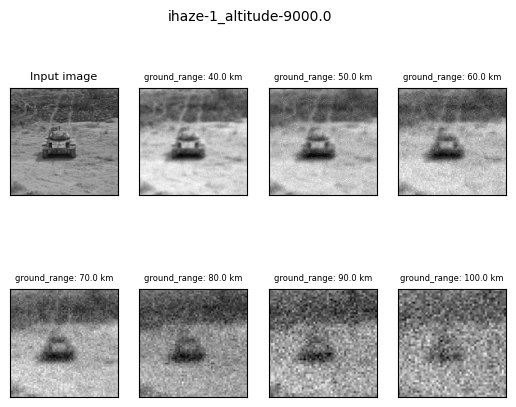

In [5]:
from nrtk.impls.perturb_image_factory.pybsm import CustomPybsmPerturbImageFactory

ground_range = np.arange(0, 101e3, 10e3)
img_gsd = 3.19 / 160.0
perturber_factory = CustomPybsmPerturbImageFactory(sensor, scenario, theta_keys=["ground_range"], thetas=[ground_range])
idx = 1
plt.subplot(2, 4, 1)
plt.title("Input image", fontdict={"fontsize": 8})
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.imshow(image, cmap="gray")
for ii in np.arange(4, ground_range.shape[0]):
    idx += 1
    plt.subplot(2, 4, idx)
    plt.suptitle(
        "ihaze-" + str(ihaze) + "_altitude-" + str(altitude),
        fontsize=10,
    )
    plt.title(
        "ground_range: " + str(ground_range[ii] / 1000) + " km",
        fontdict={"fontsize": 6},
    )
    img_out, _ = perturber_factory[ii](image, additional_params={"img_gsd": img_gsd})
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
    plt.imshow(img_out, cmap="gray")
plt.show()